In [1]:
import csv
import os

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np
from scipy.integrate import odeint
from scipy.constants import epsilon_0 as eps_0
from scipy.constants import mu_0
from scipy.constants import pi
from scipy.special import erfc

In [2]:
SUPPORTED_TISSUES = [
    'air', 'blood', 'blood_vessel', 'body_fluid', 'bone_cancellous',
    'bone_cortical', 'bone_marrow', 'brain_grey_matter', 'brain_white_matter',
    'cerebellum', 'cerebro_spinal_fluid', 'dura', 'fat', 'muscle', 'skin_dry',
    'skin_wet',
    ]

# bhte constants from IT'IS database
# https://itis.swiss/virtual-population/tissue-properties/database/
# for dry skin
k = 0.37       # thermal conductivity [W/m/°C]
rho = 1109.    # dry skin density [kg/m^3]
C = 3391.      # specific heat of dry skin [Ws/kg/°C]
m_b = 1.76e-6  # blood perfusion [m^3/kg/s] in SI units and 106 mL/min/kg in physiology literature units

# for blood
k_b = 0.52     # thermal conductivity [W/m/°C]
rho_b = 1000.  # kg/m^3
C_b = 3617.    # specific heat of blood [J/kg/°C]

# additional parameters
h_0 = 10.      # heat convection coefficient [W/m^2/°C] between the skin surface and the surrounding air
T_a = 37.      # arterial temperature [°C]     
T_c = 37.      # body core temperature [°C]
T_f = 25.      # surrounding air temperature [°C]
Q_m = 33800.   # metabolic heat generation [W/m^3]

In [3]:
def load_tissue_diel_properties(tissue, frequency):
    r"""Return conductivity, relative permitivity, loss tangent and
    penetration depth of a given tissue based on a given frequency.
    Parameters
    ----------
    tissue : str
        type of human tissue
    frequency : float
        radiation frequency
        
    Returns
    -------
    tuple
        tuple of 4 float values which represent conductivity, relative
        permitivity, loss tangent and penetration depth, respectively
    """
    if tissue not in SUPPORTED_TISSUES:
        raise ValueError(f'Unsupported tissue. Choose {SUPPORTED_TISSUES}.')
    if 1e9 > frequency > 100e9:
        raise ValueError('Invalid frequency. Choose in range [1, 100] GHz')
    tissue_diel_properties_path = os.path.join('data', 'tissue_diel_properties.csv')
    with open(tissue_diel_properties_path) as f: 
        reader = csv.reader(f) 
        for row in reader:
            if str(row[0])==tissue and float(row[1])==frequency: 
                conductivity = float(row[2]) 
                relative_permitivity = float(row[3]) 
                loss_tangent = float(row[4]) 
                penetration_depth = float(row[5])
        return (conductivity, relative_permitivity, loss_tangent, penetration_depth)

In [4]:
def initT_depth_analytic(x, k, rho, C, rho_b, C_b, m_b, h_0, T_a, T_c, T_f, Q_m):
    r"""Return the temperature distribution by solving 1-D bioheat
    equation analytically over tissue depth. This can serve as the
    initial temperature distribution before solving bioheat equation
    numerically via the pseudo-spectral method.
    
    See details in Deng and Liu. Analytical study on bioheat transfer
    problems with spatial or transient heating on skin surface or
    inside biological bodies. J Biomech Eng. 124(6): 638-649. 2002.
    
    Parameters
    ----------
    x : numpy.ndarray
        one dimensional solution domain
    k : float
        thermal conductivity of the tissue
    rho : float
        tissue density
    C : float
        heat capacity of the tissue
    rho_b : float
        blood density
    C_b : float
        blood heat capacity
    m_b : float
        blood perfusion
    h_0 : float
        heat convection coefficient between the skin surface and air
    T_a : float
        arterial temperature     
    T_c : float
        body core temperature
    T_f : float
        surrounding air temperature
    Q_m : float
        metabolic heat generation
        
    Returns
    -------
    numpy.ndarray
        initial temperature distribution befor mW energy radiation
    """
    pen_depth = np.max(x)
    w_b = m_b * rho_b * C_b
    A = w_b / k
    denom = (
        np.sqrt(A) * np.cosh(np.sqrt(A) * pen_depth)
        + (h_0 / k) * np.sinh(np.sqrt(A) * pen_depth)
        )
    numer = (
        (T_c - T_a - Q_m / w_b)
        * (np.sqrt(A) * np.cosh(np.sqrt(A) * x) + (h_0 / k) * np.sinh(np.sqrt(A) * x))
        + h_0 / k * (T_f - T_a - Q_m / w_b) * np.sinh(np.sqrt(A) * (pen_depth - x))
        )
    return T_a + Q_m / w_b + numer / denom

In [5]:
def deltaT_depth_analytic(t, pen_depth, I0, T_tr):
    r"""Return the closed-form solution of the 1-D BHTE with no blood
    perfusion considered over given simulation period, t.
    
    See details in Foster et al. Thermal response of human skin to mW
    energy: A critical review. Health Phys. 111(6): 528-541. 2016.
    
    Parameters
    ----------
    sim_time : numpy.ndarray
        Simulation time
    pen_depth : float
        energy penetration depth
    k : float
        thermal conductivity of the tissue
    rho : float
        tissue density
    C : float
        heat capacity of the tissue
    I0 : float
        incident power density of the tissue surface
    T_tr : float
        transmission coefficient into the tisse
    
    Returns
    -------
    numpy.ndarray
        rise in temperature over exposure time, t
    """
    C_1 = 2 * I0 * T_tr / np.sqrt(pi * k * rho * C)
    C_2 = I0 * T_tr * pen_depth / k
    tau = 4 / pi * (C_2 / C_1) ** 2
    return (
        C_1 * np.sqrt(t) 
        - C_2 * (1 - np.exp(t / tau) * erfc(np.sqrt(t / tau)))
        )

In [6]:
def deltaT_depth_pstd(t, N, pen_depth, k, rho, C, m_b, I0, T_tr):
    r"""Numerical solution to 1-D Pennes' bioheat transfer equation by
    using Fast Fourier Transform on spatial coordinate.
    
    Parameters
    ----------
    t : numpy.ndarray
        simulation time; exposure time in seconds
    N : int
        number of collocation points
    pen_depth : float
        energy penetration depth
    k : float
        thermal conductivity of the tissue
    rho : float
        tissue density
    C : float
        heat capacity of the tissue
    m_b : float
        blood perfusion
    I0 : float
        incident power density of the tissue surface
    T_tr : float
        transmission coefficient into the tisse
        
    Returns
    -------
    numpy.ndarray
        temperature distribution in time for each collocation point
    """
    dx = pen_depth / N
    x = np.linspace(0, pen_depth, N)
    kappa = 2 * np.pi * np.fft.fftfreq(N, d=dx)
    SAR = I0 * T_tr / (rho * pen_depth) * np.exp(-x / pen_depth)
    SAR_fft = np.fft.fft(SAR)

    # initial conditions -- prior to radiofrequency exposure
    T0 = np.zeros_like(x)
    T0_fft = np.fft.fft(T0)

    # recasting complex numbers to an array for easier handling in SciPy
    T0_fft_ri = np.concatenate((T0_fft.real, T0_fft.imag))
    
    def rhs(T_fft_ri, t, kappa, k, rho, C, m_b, SAR_fft):
        T_fft = T_fft_ri[:N] + (1j) * T_fft_ri[N:]
        d_T_fft = (
            - np.power(kappa, 2) * k * T_fft / (rho * C)
            - rho * m_b * T_fft
            + SAR_fft / C
            )
        return np.concatenate((d_T_fft.real, d_T_fft.imag)).astype(np.float64)

    T_fft_ri = odeint(rhs, T0_fft_ri, t, args=(kappa, k, rho, C, m_b, SAR_fft))
    T_fft = T_fft_ri[:, :N] + (1j) * T_fft_ri[:, N:]

    deltaT = np.empty_like(T_fft)
    for i in range(t.size):
        deltaT[i, :] = np.fft.ifft(T_fft[i, :])
    return deltaT.real

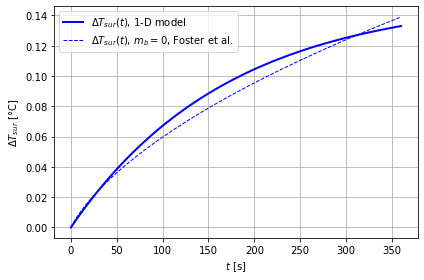

In [7]:
# frequency
f = 10e9

# conductivity, relative permitivity, tangent loss and penetration depth (Gabriel et al. 1996)
sigma, eps_r, tan_loss, pen_depth = load_tissue_diel_properties('skin_dry', f)

# `pen_depth` is the energy penetration depth into tissue, which is defined as the distance 
# beneath the surface at which the SAR has fallen to a factor of 1/e below that at the surface;
# one-half of the more commonly reported wave penetration depth
pen_depth = pen_depth / 2

# air (vacuum) resistance 
Z_air = np.sqrt(mu_0 / eps_0)

# dry skin resistance
Z_skin_dry = np.sqrt(mu_0 / (eps_r * eps_0))

# energy (Fresnel) transmission coefficient into the tissue
T_tr = 2 * Z_skin_dry / (Z_air + Z_skin_dry)

# I0 T_Tr = 10 W/m^2 at 6 GHz
I0 = 10. / T_tr

# exposure time in seconds
t = np.linspace(0, 6 * 60, 100)

# simulation
N = 101
deltaT = deltaT_depth_pstd(t, N, pen_depth, k, rho, C, m_b * 3, I0, T_tr)

# visualize the temperature change on the skin surface
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(t, deltaT[:, 0], 'b-', linewidth=2, label='$\\Delta T_{sur}(t)$, 1-D model')
ax.plot(t, deltaT_depth_analytic(t, pen_depth, I0, T_tr), 'b--', linewidth=1, label='$\\Delta T_{sur}(t)$, $m_b = 0$, Foster et al.')
ax.set_xlabel('$t$ [s]')
ax.set_ylabel('$\\Delta T_{sur}$ [°C]')
ax.legend(loc='upper left')
ax.grid()
plt.tight_layout()
plt.show()

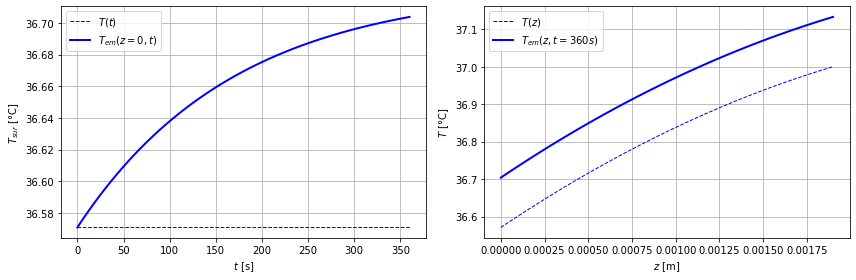

In [8]:
# visualize the temperature before and after mmWave exposure
dx = pen_depth / N
z = np.linspace(0, pen_depth, N)
T0 = initT_depth_analytic(z, k, rho, C, rho_b, C_b, m_b, h_0, T_a, T_c, T_f, Q_m)
T = T0 + deltaT

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(t, np.ones_like(t) * T0[0], 'b--', linewidth=1, label='$T(t)$')
ax1.plot(t, T[:, 0], 'b-', linewidth=2, label='$T_{em}(z=0, t)$')
ax1.set_xlabel('$t$ [s]')
ax1.set_ylabel('$T_{sur}$ [°C]')
ax1.legend(loc='upper left')
ax1.grid()

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(z, T0, 'b--', linewidth=1, label='$T(z)$')
ax2.plot(z, T[-1, :], 'b-', linewidth=2, label=f'$T_{{em}}(z, t={{{int(t[-1])}}} s)$')
ax2.set_xlabel('$z$ [m]')
ax2.set_ylabel('$T$ [°C]')
ax2.legend(loc='upper left')
ax2.grid()
plt.tight_layout()
plt.show()

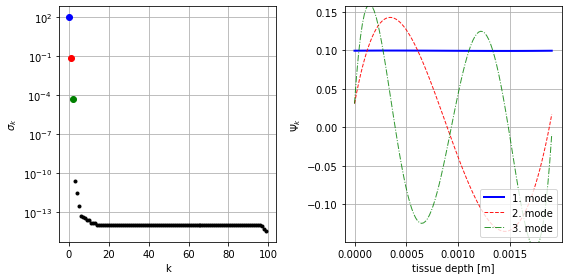

In [9]:
# proper orthogonal decomposition
U, S, VT = np.linalg.svd(deltaT.T)

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.semilogy(100 * S / np.sum(S), 'k.')
ax1.semilogy(0, 100 * S[0] / np.sum(S), 'bo')
ax1.semilogy(1, 100 * S[1] / np.sum(S), 'ro')
ax1.semilogy(2, 100 * S[2] / np.sum(S), 'go')
ax1.set_xlabel('k')
ax1.set_ylabel('$\\sigma_k$')
ax1.grid()

colors = ['b', 'r', 'g']
linestyles = ['-', '--', '-.']
linewidths = [2, 1, 1]
alphas = [1, 0.9, 0.8]
ax2 = fig.add_subplot(1, 2, 2)
for idx, (c, ls, lw, alpha) in enumerate(zip(colors, linestyles, linewidths, alphas)):
    ax2.plot(z, np.real(U[:, idx]), c=c, linewidth=lw, linestyle=ls, alpha=alpha, label=f'{idx + 1}. mode')
ax2.set_ylim(1.1 * np.min(U[:, 1].real), 1.1 * np.max(U[:, 1].real))
ax2.set_xlabel('tissue depth [m]')
ax2.set_ylabel('$\\Psi_k$')
ax2.grid()
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [10]:
def deltaT_3d_pstd(t, N, area, pen_depth, k, rho, C, m_b, I0, T_tr):
    r"""Numerical solution to 1-D Pennes' bioheat transfer equation by
    using Fast Fourier Transform on spatial coordinate.
    
    Parameters
    ----------
    t : numpy.ndarray
        simulation time; exposure time in seconds
    N : int
        number of collocation points
    area : tuple
        length and width of the heated surface area
    pen_depth : float
        energy penetration depth
    k : float
        thermal conductivity of the tissue
    rho : float
        tissue density
    C : float
        heat capacity of the tissue
    m_b : float
        blood perfusion
    I0 : float
        incident power density of the tissue surface
    T_tr : float
        transmission coefficient into the tisse
        
    Returns
    -------
    numpy.ndarray
        temperature distribution in time for each collocation point
    """
    Nx, Ny, Nz = 3 * [N]
    X, Y = area
    Z = pen_depth
    x = np.linspace(-X/2, X/2, Nx)
    y = np.linspace(-Y/2, Y/2, Ny)
    z = np.linspace(0, Z, Nz)
    dx, dy, dz = X / Nx, Y / Ny, Z / (Nz)

    SAR_ref = I0 * T_tr / (rho * pen_depth)
    SAR_sur = SAR_ref * np.exp(-(x**2 + y.reshape(-1, 1)**2) / (2 * (SAR_ref * 3e-4)**2))
    SAR = np.empty(shape=(Nx, Ny, Nz))
    for idx in range(Nz):
        _SAR = SAR_sur * np.exp(-z[idx] / pen_depth)
        SAR[:, :, idx] = _SAR

    kappax = 2 * np.pi * np.fft.fftfreq(Nx, d=dx)
    kappay = 2 * np.pi * np.fft.fftfreq(Ny, d=dy)
    kappaz = 2 * np.pi * np.fft.fftfreq(Nz, d=dz)

    T0 = np.zeros_like(SAR)
    T0 = T0.ravel()

    def RHS(T, t, kappa, k, rho, C, m_b, SAR):
        T = T.reshape(Nx, Ny, Nz)
        T_fft = np.fft.fft(T)
        dd_T_fft = -np.power(kappa, 2) * T_fft
        dd_T = np.fft.ifft(dd_T_fft)

        dT_dt = (
            k * dd_T / (rho * C)
            - rho * m_b * T
            + SAR / C
            )
        return dT_dt.real.ravel()

    T = odeint(RHS, T0, t, args=(kappax, k, rho, C, m_b, SAR))
    return T.reshape(-1, Nx, Ny, Nz)

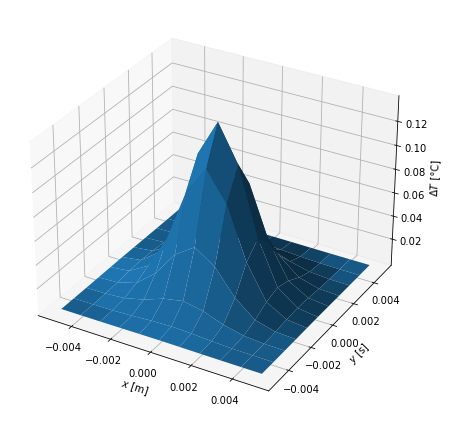

In [11]:
# temperature change distribution on the surface
t = np.linspace(0, 360, 10)
N = 11
area = (0.01, 0.01)
x = np.linspace(-area[0]/2, area[0]/2, N)
y = np.linspace(-area[0]/2, area[1]/2, N)
T = deltaT_3d_pstd(t, N, area, pen_depth, k, rho, C, m_b * 3, I0, T_tr)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
xmesh, ymesh = np.meshgrid(x, y)
ax.plot_surface(xmesh, ymesh, T[-1, :, :, 0])
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [s]')
ax.set_zlabel('$\\Delta T$ [°C]')
plt.tight_layout()
plt.show()

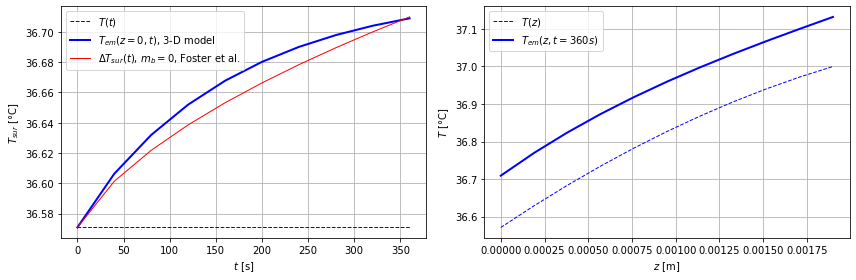

In [18]:
# visualize the temperature (depth-wise) before and after mmWave exposure
z = np.linspace(0, pen_depth, N)
T0 = initT_depth_analytic(z, k, rho, C, rho_b, C_b, m_b, h_0, T_a, T_c, T_f, Q_m)

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(t, np.ones_like(t) * T0[0], 'b--', linewidth=1, label='$T(t)$')
ax1.plot(t, np.ones_like(t) * T0[0] + np.max(T[:, :, :, 0], axis=(1, 2)), 'b-', linewidth=2, label='$T_{em}(z=0, t)$, 3-D model')
ax1.plot(t, np.ones_like(t) * T0[0] + deltaT_depth_analytic(t, pen_depth, I0, T_tr), 'r-', linewidth=1, label='$\\Delta T_{sur}(t)$, $m_b = 0$, Foster et al.')
ax1.set_xlabel('$t$ [s]')
ax1.set_ylabel('$T_{sur}$ [°C]')
ax1.legend(loc='upper left')
ax1.grid()

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(z, T0, 'b--', linewidth=1, label='$T(z)$')
ax2.plot(z, T0 + T[-1, N//2, N//2, :], 'b-', linewidth=2, label=f'$T_{{em}}(z, t={{{int(t[-1])}}} s)$')
ax2.set_xlabel('$z$ [m]')
ax2.set_ylabel('$T$ [°C]')
ax2.legend(loc='upper left')
ax2.grid()
plt.tight_layout()
plt.show()